# Линейная регрессия: переобучение и регуляризация
## Подготовил: Аббазов Валерьян
### Группа: 1191б/1

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации `Shift+Tab`. Нажатие `Tab` после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [91]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __`pandas.read_csv`__ в переменную __`df`__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [92]:
df = pd.read_csv('./data/bikes_rent.csv')
df[:5]

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600

Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* `season`: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`: 0 - 2011, 1 - 2012
* `mnth`: от 1 до 12
* `holiday`: 0 - нет праздника, 1 - есть праздник
* `weekday`: от 0 до 6
* `workingday`: 0 - нерабочий день, 1 - рабочий день
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`: температура в Цельсиях
* `atemp`: температура по ощущениям в Цельсиях
* `hum`: влажность
* `windspeed(mph)`: скорость ветра в милях в час
* `windspeed(ms)`: скорость ветра в метрах в секунду
* `cnt`: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальными признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных.

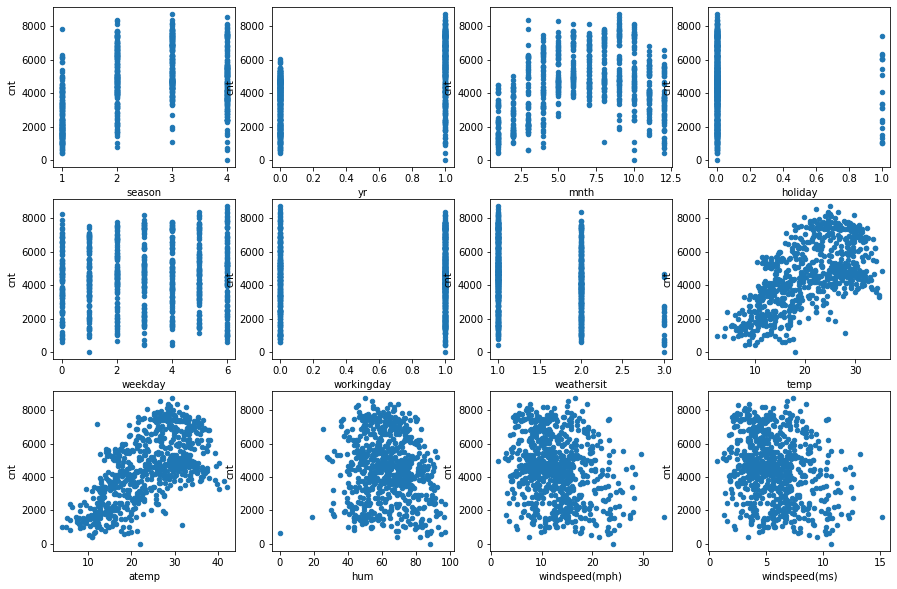

In [93]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[int(idx / 4), int(idx % 4)])

------

### Блок 1. Ответьте на вопросы (каждый 0.5 балла):

1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: зимой кол-во проката снижается, выражена сезоннсть
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp и atemp
   
------

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: `corr` и `corrwith`. Метод `df.corr` вычисляет матрицу корреляций всех признаков из датафрейма. Методу `df.corrwith` нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из `df` и этого датафрейма.

In [94]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df.drop('cnt', axis=1).corrwith(df['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [95]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: `temp` и `atemp` (коррелируют по своей природе) и два `windspeed` (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод `mean`), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [96]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода `scale`.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [97]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [98]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
clf = LinearRegression()
clf.fit(X, y)

print('Коэффиценты весов:\n')
for i, elem in enumerate(zip(clf.coef_, df.columns), 1):
    print(f'{i}.) {elem[1]} = {elem[0]}')

Коэффиценты весов:

1.) season = 570.8719592302759
2.) yr = 1021.9635898212942
3.) mnth = -141.30585587144665
4.) holiday = -86.75647149074891
5.) weekday = 137.2260362759306
6.) workingday = 56.390724502512256
7.) weathersit = -330.2291534403052
8.) temp = 367.46916495965974
9.) atemp = 585.5606071882255
10.) hum = -145.6111431908375
11.) windspeed(mph) = 12457587117893.193
12.) windspeed(ms) = -12457587118091.646


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в `X` есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такую ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой `temp-atemp` чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Решение проблемы мультиколлинеарности состоит в __регуляризации__ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется __Lasso__, а во втором — __Ridge__. Подробнее об этом также было рассказано в лекции.

Обучите регрессоры `Ridge` и `Lasso` с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [99]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией
clf = Lasso()
clf.fit(X, y)
print('Коэффиценты весов:\n')
for i, elem in enumerate(zip(clf.coef_, df.columns), 1):
    print(f'{i}.) {elem[1]} = {elem[0]}')

Коэффиценты весов:

1.) season = 560.2416160308867
2.) yr = 1019.4634940657196
3.) mnth = -128.73062703678738
4.) holiday = -86.15278133371112
5.) weekday = 137.3478939049632
6.) workingday = 55.21237064135662
7.) weathersit = -332.3698569623486
8.) temp = 376.36323620969586
9.) atemp = 576.5307935045539
10.) hum = -144.12915500348598
11.) windspeed(mph) = -197.13968940249575
12.) windspeed(ms) = -2.8039823678320867e-08


In [100]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией
clf = Ridge()
clf.fit(X, y)
print('Коэффиценты весов:\n')
for i, elem in enumerate(zip(clf.coef_, df.columns), 1):
    print(f'{i}.) {elem[1]} = {elem[0]}')

Коэффиценты весов:

1.) season = 563.0645722520179
2.) yr = 1018.9483787875289
3.) mnth = -131.8733202824773
4.) holiday = -86.74609799709266
5.) weekday = 138.00511117871903
6.) workingday = 55.90311037506455
7.) weathersit = -332.3497884990734
8.) temp = 386.4578891919391
9.) atemp = 566.3470470600361
10.) hum = -145.07132729867237
11.) windspeed(mph) = -99.25944108172293
12.) windspeed(ms) = -99.25944115441054


------

### Блок 2.  Поясните, 

каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

* __Ваш ответ (1 балл)__: регуляризация добавляет ограничения к весам модели, т.е. не даёт им становится слишком большими(что происходило из-за  мультиколлинеарности), тем самым предотвращается переобучение

------

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [101]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
for i, alpha in enumerate(alphas):
    coefs_lasso[i] = Lasso(alpha=alpha).fit(X, y).coef_
    coefs_ridge[i] = Ridge(alpha=alpha).fit(X, y).coef_

In [102]:
print(coefs_lasso[:1], coefs_lasso.shape)
print(coefs_ridge[:1], coefs_lasso.shape)

[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80398237e-08]] (10, 12)
[[ 563.06457225 1018.94837879 -131.87332028  -86.746098    138.00511118
    55.90311038 -332.3497885   386.45788919  566.34704706 -145.0713273
   -99.25944108  -99.25944115]] (10, 12)


Визуализируем динамику весов при увеличении параметра регуляризации:

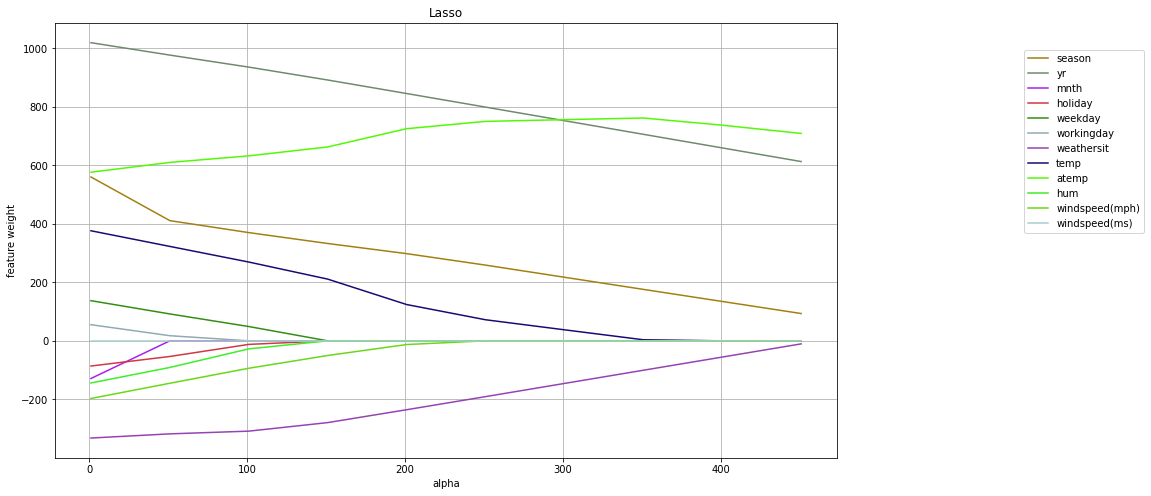

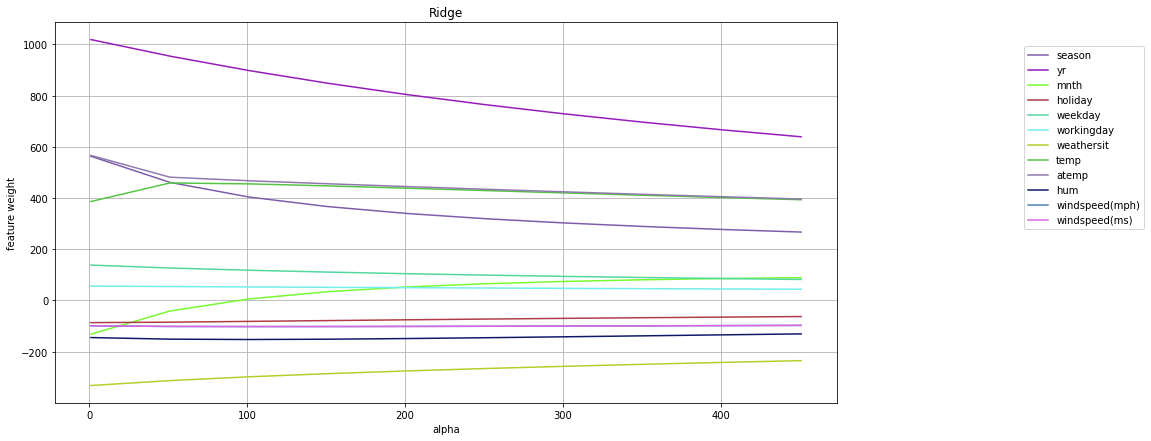

In [103]:
plt.figure(figsize=(14, 8))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")
plt.grid()

plt.figure(figsize=(14, 7))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")
plt.grid();

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

------

### Блок 3. Ответьте на вопросы (каждый 0.25 балла):

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же `alpha`?
    * Ответ: Lasso
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: Веса обнулятся
3. Можно ли утверждать, что Lasso исключает один из признаков `windspeed` при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: Lasso - да, Ridge - нет
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Lasso, т.к. исключает один из коррелирующих признаков
------

Далее будем работать с Lasso.

Итак, мы видим, что при изменении `alpha` модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее `alpha`. 

Для этого, во-первых, нам __нужна метрика качества__. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, __на каких данных эту метрику считать__. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные «новые» данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения `alpha`, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на `K` частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из `alpha` и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера `len(alpha) x k`, `k = 3` (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по `alphas`; для сопоставления с матрицей MSE лучше использовать переменную регрессора `alphas`.

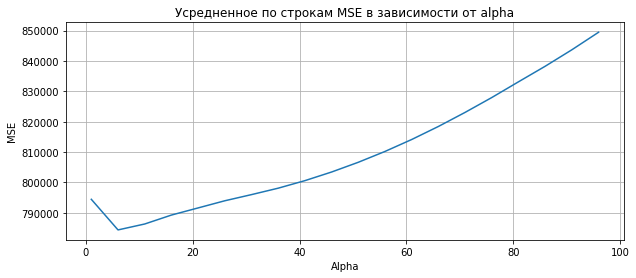

Выбранное alpha = 6

Коэффиценты весов:
1.) weathersit = -330.55985673998146
2.) windspeed(mph) = -191.7714084713612
3.) hum = -140.00740550068855
4.) mnth = -100.03952614356626
5.) holiday = -83.2939598752991
6.) windspeed(ms) = -2.6843848098919856e-08
7.) workingday = 51.557085614073884
8.) weekday = 132.50446549095798
9.) temp = 370.6798550300324
10.) season = 532.0189828413535
11.) atemp = 581.3969310654994
12.) yr = 1015.0602226430597


In [109]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
clf = LassoCV(alphas=alphas).fit(X, y)

plt.figure(figsize=(10, 4))
plt.plot(clf.alphas_, np.mean(clf.mse_path_, axis=1))
plt.title('Усредненное по строкам MSE в зависимости от alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.grid()
plt.show()
# plt.plot(clf.alphas_, clf.mse_path_)

print(f'Выбранное alpha = {clf.alpha_}')

print('\nКоэффиценты весов:')
for i, elem in enumerate(sorted(zip(clf.coef_, df.columns)), 1):
    print(f'{i}.) {elem[1]} = {elem[0]}')

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

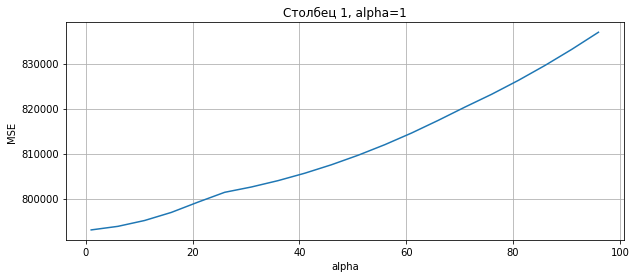

In [107]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
mse = clf.mse_path_
for i in range(3):
    min_idx = clf.mse_path_[:,i].argmin()

    plt.figure(figsize=(10, 4))
    plt.title(f'Столбец {i}, alpha={clf.alphas_[min_idx]}')
    plt.plot(clf.alphas_, mse[:,i])
    plt.grid()
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

------

### Блок 4. Ответьте на вопросы (каждый 0.5 балла):

1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке «Знакомство с данными». Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

    * Ответ: Признаки: temp, season, atemp, yr (сезон, температура, год). На графиках прослеживается линейная зависимость. Для признака год, можно сделать вывод что с течением времени прокат становится популярнее, но у нас выборка всего за два года, так что утвержать рано. Для температуры утверждение верно с увеличением температуры, кол-во проката возрастает, но полагаю до определённого порога, т.к в очень сильную жару популярность проката снизится. Про сезонность к лету-осени кол-во проката увеличивается, но к зиме - весне снова падает.

2. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

    * Ответ: Признаки: weathersit, windspeed(mph), hum (оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман), скорость ветраб влажность. Убывающая линейная зависимость прослеживается, что логично, так как увеличение этих признаков соответствует ухудшению погоды, а при плохой погоде вряд ли много людей возьмёт велосипеды.

4. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: Признак windspeed(ms), признак линейно зависим, но он дублирует windspeed(mph), поэтому и был исключён.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.